In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import random
import copy
import collections
import itertools
import pickle
from ipywidgets import interact
import wordcloud

Loading the data from other notebooks

In [2]:
data_combined = pickle.load(open('/data/BobbyDobo/data_combined.p', 'rb'))
flattened_rec_item = pickle.load(open('/data/BobbyDobo/flattened_rec_item.p', 'rb'))
ingredient_relations = pickle.load(open('/data/BobbyDobo/ingredient_relations.p', 'rb'))
vec_ingredient_relations = pickle.load(open( "/data/BobbyDobo/df_ingredient_relations.p", "rb"))
ingredient_counts = pickle.load(open("/data/BobbyDobo/ingredient_counts.p", "rb" ))

In this modeling notebook, I will explore other ways to make ingredient suggestions.

In [3]:
df_ingredient_relations = pd.DataFrame(flattened_rec_item, columns=['id','ingredient'])

Here is a wordcloud to inspire algorithm possibilities! Chicken is rather large as is virgin, cilantro and annoyingly the word chopped. It looks like an algorithm that chooses most liked ingredients wouldn't do too badly and may make some good suggestions. The mst common ingredients are mostly stuff that everyone has, minus some of the spices such as cilantro, sesame, and maybe some of the cheeses.

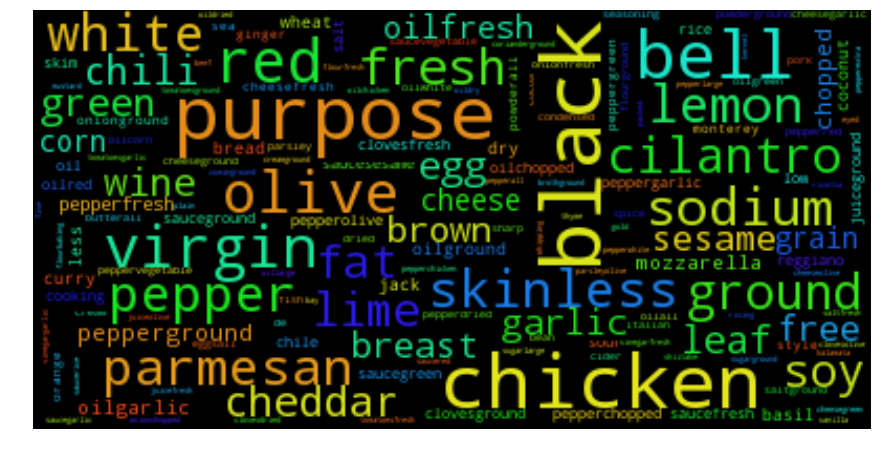

In [4]:
ingredient_cloud = \
    wordcloud.WordCloud(max_words=1000, max_font_size=40, relative_scaling=.5).generate(\
        ''.join(df_ingredient_relations['ingredient'].tolist()))
plt.figure(figsize=(15,10))
plt.imshow(ingredient_cloud)
plt.axis("off");

## Suggestion exploration 
For suggestions we will look at:
- just combining the relation Counters and selecting the highest counts 
- converting the relation Counters to percentages then joining (This will be explored in Modeling)
- combining the relation Counters and selection a random ingredient from the weighted list (This will be explored in Modeling)

This combine relation combines the Counts of how often each ingredient shares a recipe with another ingredient.

In [5]:
def combine_relations(indexes, relations):
    """Returns combined collection.Counters which does not have redundancies

    Keyword arguments:
    indexes-- columns to look at in relations Counter dictionary
    relations-- relations dictionary which includes the collections.Counters for each ingredient
    """
    combined = collections.Counter()
    for x in indexes:
        if x in relations:
            combined = combined + relations[x]
    for x in indexes:
        if x in combined:
            del combined[x]
    return combined

def count_suggestion(combined, selected=[], n=1, ignore=None):
    """Returns a list of suggestions based on the most common items in combined paramater

    Keyword arguments:
    combined-- the combined collection.Counter used for prediction 
    selected-- list of items already used in the cart used to base predictions off of (default= empty list)
    n-- number of items to suggest (default= 1)
    ignore-- list of items to ignore and never suggest
    """
    temp_selected = copy.deepcopy(selected)
    if ignore != None:
        temp_selected = temp_selected + ignore
    drawn = []
    for x in combined.most_common():
        if x[0] in temp_selected:
            pass
        else:
            temp_selected.append(x[0])
            drawn.append(x[0])
            if len(drawn) == n:
                break
    return drawn

This combine relation combines the percentages an ingredient appears in a recipe with an ingredient. 

In [6]:
def combine_perc_relations(indexes, relations):
    """Returns combined dictionary which does not have redundancies with ingredient, additive.percentage pairings

    Keyword arguments:
    indexes-- columns to look at in relations Counter dictionary
    relations-- relations dictionary which includes the collections.Counters for each ingredient
    """
    combined = {}
    for ingredient in indexes:
        if ingredient in relations:
            ingredient_sum = sum(relations[ingredient].values())
            for item in relations[ingredient]:
                count = relations[ingredient][item]
                if item in combined:
                    combined[item] = combined[item] + count/ingredient_sum
                else:
                    combined[item] = count/ingredient_sum
    for ingredient in indexes:
        if ingredient in combined:
            del combined[ingredient]
    return combined

def perc_suggestion(combined, selected=[], n=1, ignore=None):
    """Returns a list of suggestions based on adding percentages that ingredient occured with another ingredient

    Keyword arguments:
    combined-- the combined dictionary from combine_perc_relations()
    selected-- list of items already used in the cart used to base predictions off of (default= empty list)
    n-- number of items to suggest (default= 1)
    ignore-- list of items to ignore and never suggest
    """
    temp_selected = copy.deepcopy(selected)
    drawn = []
    if ignore != None:
        temp_selected = temp_selected + ignore 
    temp_sorted = copy.deepcopy(combined)
    df = pd.DataFrame(index=temp_sorted.keys(), columns=['ingredient', 'mod.prob'])
    df['val'] = temp_sorted.values()
    df = df.sort_values(['val'], ascending=False)
    for ingredient in df.index:
        if ingredient in temp_selected:
            pass
        else:
            temp_selected.append(ingredient)
            drawn.append(ingredient)
            if len(drawn) == n:
                break
    return drawn

I wonder if the two algorithms for finding the best mach is significantly different. I will make an interact for the both of them, and see if there is a significant difference.

## Interact Widgets
Here you can interactively see how each algorithm differes in it's predictions. Note that the counter and the percentages algorithms, only have minor differences. Both would require ignore lists to make more useful predictions.

In [7]:
cart_relations = combine_relations(['ice cream', 'bananas', 'toys'], ingredient_relations)
def cart_example1(add):
    """Function used to setup interact for count_suggestion

    Keyword arguments:
    add-- name of ingredient to add to the cart
    """
    cart = ['apple','rice']
    cart.append(add)
    print('Your cart:', cart, '\n',
      'Suggestions:', count_suggestion(cart_relations, cart, 10))
interact(cart_example1, add='text', __manual=True);

In [8]:
cart_relations = combine_perc_relations(['ice cream', 'bananas', 'toys'], ingredient_relations)
def cart_example2(add):
    """Function used to setup interact for cart_suggestion

    Keyword arguments:
    add-- name of ingredient to add to the cart
    """
    cart = ['apple','rice']
    cart.append(add)
    print('Your cart:', cart, '\n',
      'Suggestions:', perc_suggestion(cart_relations, cart, 10))
interact(cart_example2, add='text', __manual=True);

For the most part they seem to be very similar. For small-medium amounts of ingredients, the count based suggestion the exact same ingredients are suggested. For the percentage based suggestion, there is more variability. However, with larger sets of ingredients, the two lists become very similar. This is completely due to how often the most common ingredients appear in all recipies. The more ingredients I include, the more prevelant they will appear. Unless I do some weighting against too common of ingredients, that won't go away.

For more variability, I wonder how a weighted random suggestion would do. It's sure to be much more variable than the other two approaches that I made.

In [9]:
def rand_count_suggestion(combined, selected=[], n=1, ignore=None):
    """Returns a list of suggestions using random values based on weighted Counter values

    Keyword arguments:
    combined-- the combined collection.Counter used for prediction 
    selected-- list of items already used in the cart used to base predictions off of (default= empty list)
    n-- number of items to suggest (default= 1)
    ignore-- list of items to ignore and never suggest
    """
    temp_selected = copy.deepcopy(selected)
    if ignore != None:
        temp_selected = temp_selected + ignore
    drawn = []
    for x in combined:
        # Code line below created using this resource
        # http://stackoverflow.com/questions/9084647/how-can-i-get-a-weighted-random-pick-from-pythons-counter-class
        x = next(itertools.islice(combined.elements(), random.randrange(sum(combined.values())), None))
        if x in temp_selected:
            pass
        else:
            temp_selected.append(x)
            drawn.append(x)
            if len(drawn) == n:
                break
    return drawn

In [10]:
cart_relations = combine_relations(['ice cream', 'bananas', 'toys'], ingredient_relations)
def cart_example3(add):
    """Function used to setup interact for rand_count_suggestion

    Keyword arguments:
    add-- name of ingredient to add to the cart
    """
    cart = ['apple','rice']
    cart.append(add)
    print('Your cart:', cart, '\n',
      'Suggestions:', rand_count_suggestion(cart_relations, cart, 10))
interact(cart_example3, add='text', __manual=True);

## Algorithm Comparison Tables
Here are tables that directly compares the three algorithms. When the most some of the most common ingredients are removed, the counter and percentage approach become more significantly different. The weighted counter approach continues to show common items, but also includes rather interesting and bizzard items too! All three would be useful for ingredient prediction.

In [11]:
comparison_data = [['pineapple', 'oranges', 'chicken'], 
                   ['soy sauce', 'cumin', 'basil'], 
                   ['green peas', 'carrots', 'rice'],
                   ['strawberries', 'sugar', 'flour']]
common_ignore = \
['salt',
 'butter',
 'all-purpose flour',
 'eggs',
 'sugar',
 'onions',
 'large eggs',
 'baking powder',
 'water',
 'pepper',
 'unsalted butter',
 'flour',
 'olive oil']

comb = []
perc = []
rand = []
for x in comparison_data:
    comb_relation = combine_relations(x, ingredient_relations)
    per_relation = combine_perc_relations(x, ingredient_relations)
    
    comb.append(count_suggestion(comb_relation, x, 15, ignore= common_ignore))
    perc.append(perc_suggestion(per_relation, x, 15, ignore= common_ignore))
    rand.append(rand_count_suggestion(comb_relation, x, 15, ignore= common_ignore))
example = pd.DataFrame(index=[x for x in range(len(comparison_data))])
example['counter'] = comb
example['percent'] = perc
example['rand_weighted'] = rand
example['orig'] = comparison_data
pd.set_option('max_colwidth', 1000)
example

,counter,percent,rand_weighted,orig
0,"[garlic, garlic cloves, vegetable oil, ground black pepper, soy sauce, carrots, ground cumin, tomatoes, kosher salt, oil, ginger, chili powder, chicken broth, black pepper, green onions]","[garlic, vegetable oil, garlic cloves, soy sauce, purple onion, green onions, ground black pepper, ground cumin, carrots, lime, fish sauce, black pepper, kosher salt, cilantro, corn starch]","[lime, garam masala, starch, carrots, sauce, tomatoes, curry powder, crushed garlic, lemon juice, garlic cloves, butter oil, grated parmesan cheese, lemon, bacon, harissa]","[pineapple, oranges, chicken]"
1,"[garlic, sesame oil, green onions, vegetable oil, scallions, garlic cloves, corn starch, ginger, carrots, rice vinegar, fresh ginger, oil, brown sugar, chili powder, ground black pepper]","[garlic, garlic cloves, chili powder, green onions, sesame oil, vegetable oil, carrots, ginger, black pepper, scallions, tomatoes, cilantro, ground black pepper, oregano, oil]","[peanut oil, scallions, malt vinegar, pears, kosher salt, rice noodles, sugar pea, tumeric, persian cucumber, cooked rice, eggplant, finely chopped onion, corn starch, szechwan peppercorns, cinnamon]","[soy sauce, cumin, basil]"
2,"[garlic, garlic cloves, soy sauce, ground black pepper, vegetable oil, green onions, sesame oil, celery, potatoes, kosher salt, ginger, black pepper, oil, red bell pepper, scallions]","[garlic, garlic cloves, vegetable oil, ground black pepper, soy sauce, oil, green onions, tomatoes, ginger, potatoes, cilantro leaves, ground cumin, black pepper, ground turmeric, green chilies]","[shiitake, celery, chicken broth, english cucumber, swiss chard, scallions, water chestnuts, minced ginger, cucumber, dried bonito flakes, ground pork, avocado, soba, cilantro, dry mustard]","[green peas, carrots, rice]"
3,"[soy sauce, garlic, vegetable oil, milk, corn starch, garlic cloves, vanilla extract, sesame oil, oil, green onions, carrots, scallions, kosher salt, baking soda, ground black pepper]","[vanilla extract, milk, garlic, vegetable oil, corn starch, heavy cream, whipping cream, powdered sugar, soy sauce, ground black pepper, oil, garlic cloves, granulated sugar, fresh lemon juice, baking soda]","[vegetable oil, extra-virgin olive oil, sesame oil, cooking spray, oil, sliced almonds, pasta sauce, peaches, chicken, vinegar, cooked rice, brown sugar, vanilla, thai chile, collard greens]","[strawberries, sugar, flour]"


In conclusion, both the percentage and count based suggestions are nearly the same with larger sets of ingredients if few words are ignored. Even small sets of ingredients are incredibly similar. To remove that issue, large lists of common ingredients must be placed in the ignore parameter so that unique items appear. With the random weighted count based suggestion, unique items will appear much more often, however unrelated items will also occur. 

All three approaches have their pros and cons:
- The counter method may be useful for finding most common ingredients, 
- The percent method may be good for more unique pairings, 
- The random weighted method would be useful for more interesting suggestions.